In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'C:\Users\khakh\Downloads\archive (1)\insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: Smoking

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance - TARGET

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Видно, что распределение целевой переменной сильно смещено вправо (med=9382, max=63770).
Проверим, есть ли NaN.

In [8]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

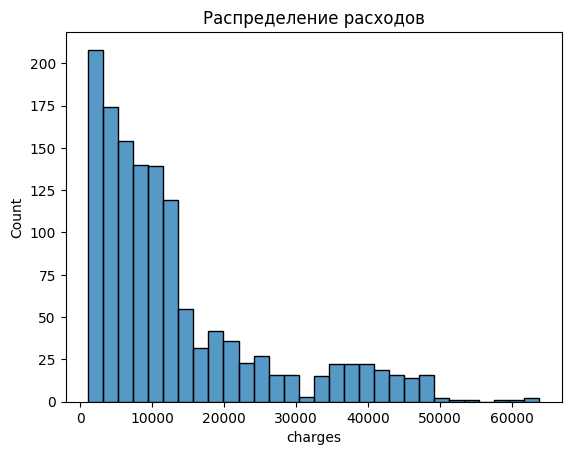

In [25]:
sns.histplot(df['charges'])
plt.xlabel("charges")
plt.title("Распределение расходов")
plt.show()

Прологарифмируем:

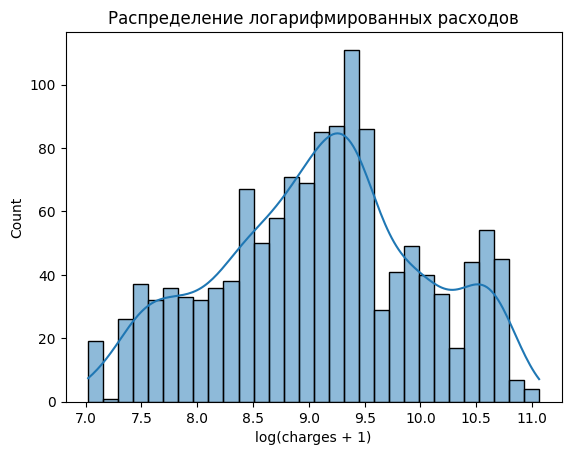

In [24]:
# Логарифмируем charges
df["log_charges"] = np.log1p(df["charges"])

# Строим гистограмму
sns.histplot(df["log_charges"], bins=30, kde=True)
plt.xlabel("log(charges + 1)")
plt.title("Распределение логарифмированных расходов")
plt.show()

Видим, что распределение мультимодальное. Попробуем разделить данные по какому-либо признаку и посмотреть распределения. Логично предположить, что признак smoker дает два подраспределения.

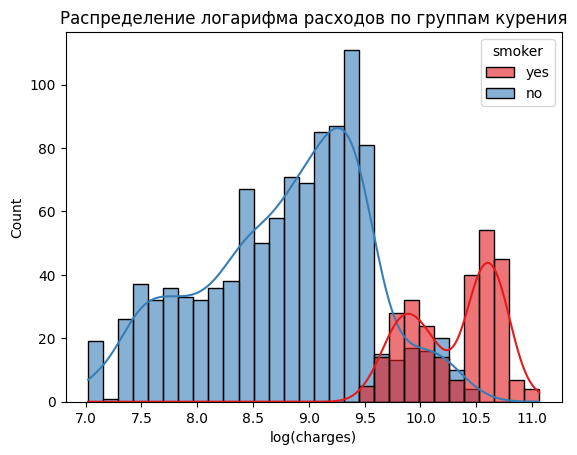

In [36]:
sns.histplot(data=df, x="log_charges", hue="smoker", bins=30, kde=True, palette="Set1", alpha=0.6)
plt.title("Распределение логарифма расходов по группам курения")
plt.xlabel("log(charges)")
plt.ylabel("Count")
plt.show()

Видим, что курение сильный предиктор повышенных медицинских расходов.

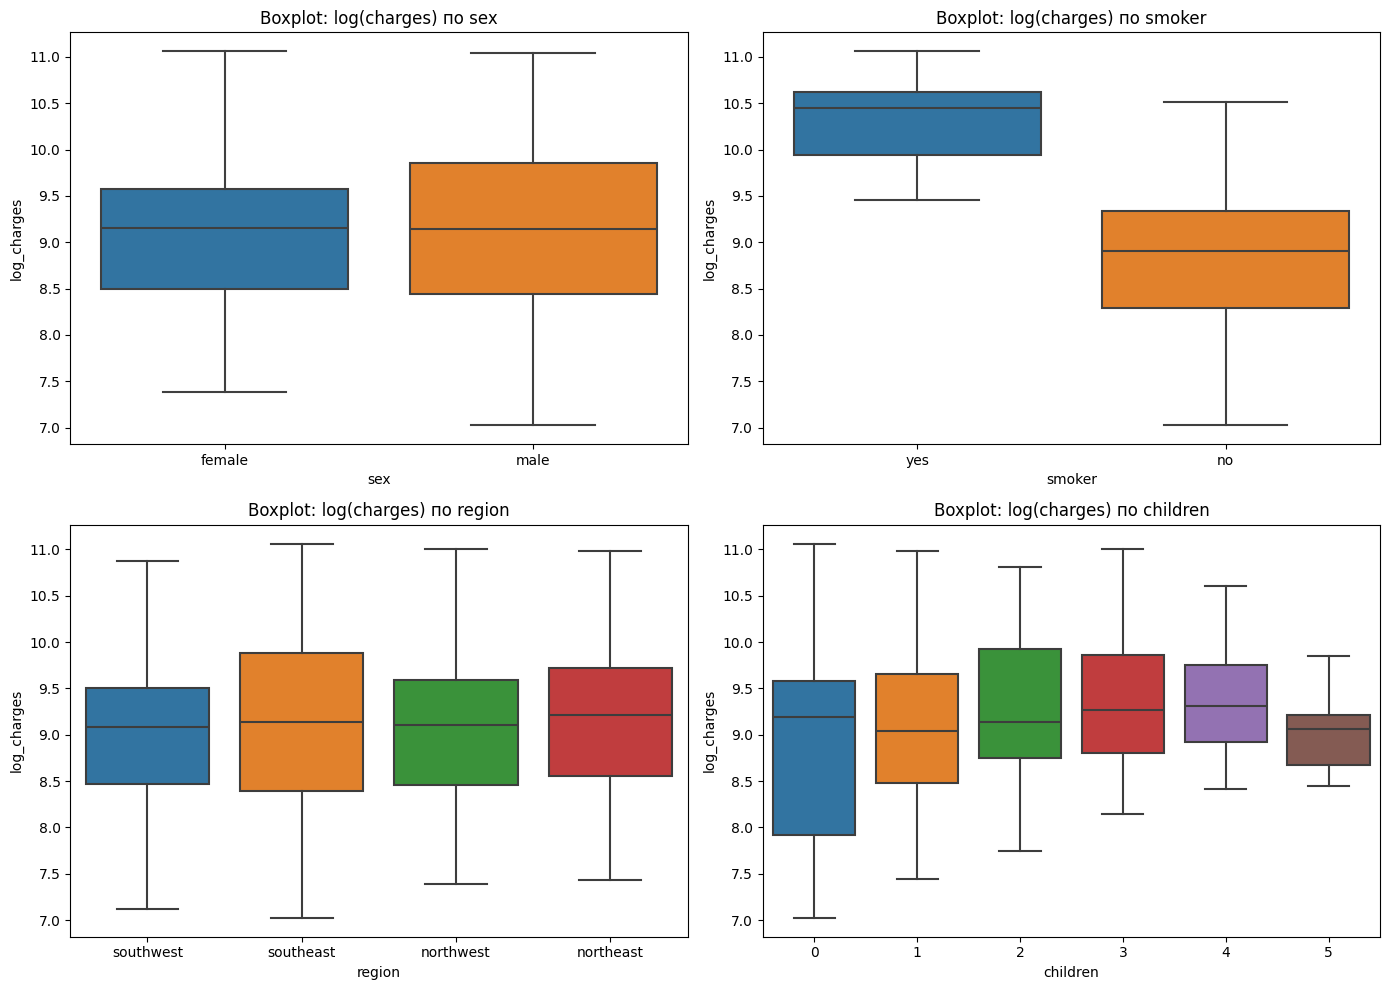

In [45]:
categorical_vars = ["sex", "smoker", "region", "children"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    sns.boxplot(x=var, y='log_charges', data=df, ax=axes[i])
    axes[i].set_title(f"Boxplot: log(charges) по {var}")
                      
plt.tight_layout()
plt.show()

Видно, что log_charges очень слабо связан с остальными признаками.
Построим scatterplot, чтобы увидеть насколько нелинейна связь.

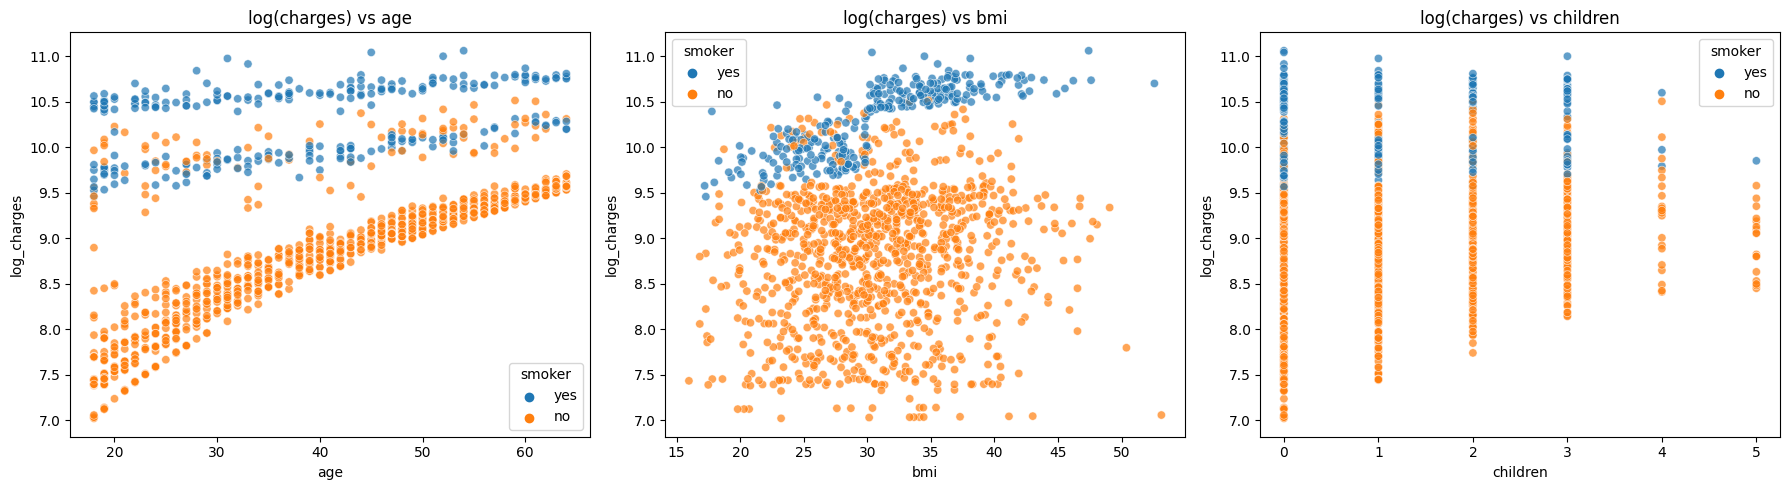

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df, x='age', y="log_charges", hue='smoker', alpha=0.7, ax=axes[0])
axes[0].set_title("log(charges) vs age")

sns.scatterplot(data=df, x='bmi', y="log_charges", hue='smoker', alpha=0.7, ax=axes[1])
axes[1].set_title("log(charges) vs bmi")

sns.scatterplot(data=df, x='children', y="log_charges", hue='smoker', alpha=0.7, ax=axes[2])
axes[2].set_title("log(charges) vs children")

plt.tight_layout()
plt.show()

In [ ]:
Видим, что у курильщиков значительно выше траты и слабо связанны с возрастом в отличие от некурильщиков.


In [53]:
cross_smoker_sex = pd.crosstab(df["smoker"], df["sex"], normalize="columns")
cross_smoker_region = pd.crosstab(df["smoker"], df["region"], normalize="columns")
cross_sex_region = pd.crosstab(df["sex"], df["region"], normalize="columns")

cross_smoker_sex

sex,female,male
smoker,,
no,0.826284,0.764793
yes,0.173716,0.235207


In [54]:
cross_smoker_region

region,northeast,northwest,southeast,southwest
smoker,,,,
no,0.79321,0.821538,0.75,0.821538
yes,0.20679,0.178462,0.25,0.178462


In [55]:
cross_sex_region

region,northeast,northwest,southeast,southwest
sex,,,,
female,0.496914,0.504615,0.480769,0.498462
male,0.503086,0.495385,0.519231,0.501538


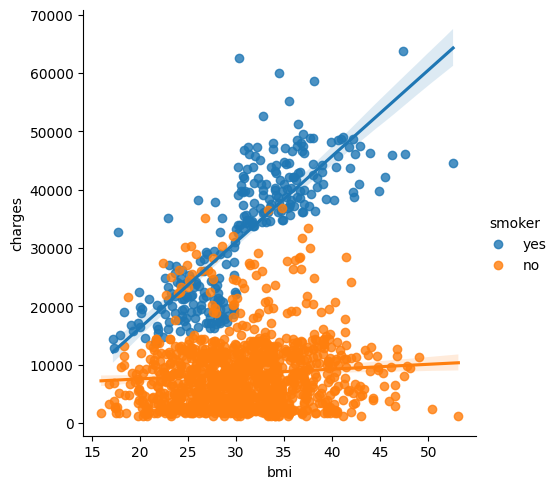

In [56]:
sns.lmplot(x="bmi", y="charges", hue="smoker", data=df)
plt.show()

Видно, что сильная зависимость от bmi есть только для курильщиков.

In [57]:
correlation_with_charges = df.corr(numeric_only=True)["charges"].sort_values(ascending=False)
correlation_with_charges

charges        1.000000
log_charges    0.892996
age            0.299008
bmi            0.198341
children       0.067998
Name: charges, dtype: float64

Создадим бейзлайновую модель.

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# закодируем категориальные признаки one-hot-encoderом
df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop(columns=["charges", "log_charges"])
y = df_encoded["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_baseline = LinearRegression()
lr_baseline.fit(X_train, y_train)

y_pred = lr_baseline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

5796.2846592762735

charges_std=12110, rmse=5796 - значит модель уже улавливает часть структуры данных.
Посмотрим на остатки.

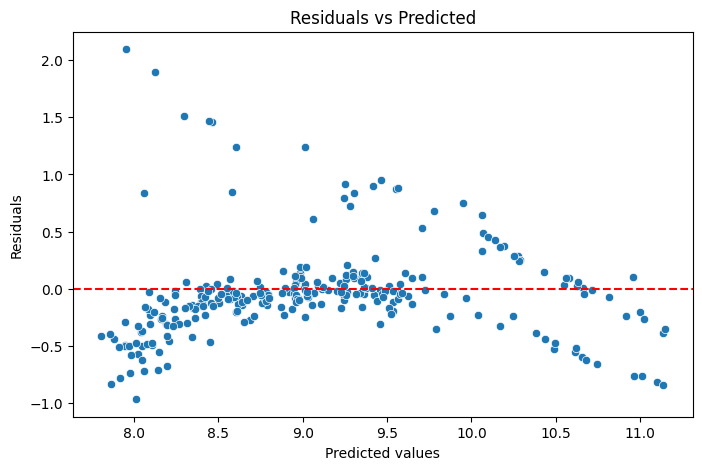

In [64]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

Явно видны две зависимости. Из EDA можно заметить, что отклонения выглядят
очень похоже на зависимость трат от индекса массы разделенные по группам курильщик/не курильщик. 
Поэтому сделаем модель с взаимодействием признаков bmi, smoker.

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df_encoded["bmi_smoker"] = df_encoded["bmi"] * df_encoded["smoker_yes"]

# Разделяем данные
X = df_encoded.drop(columns=["charges", "log_charges"])
y = df_encoded["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем модель
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание и метрика
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

RMSE: 4573.807686290385


Стало чуть лучше. Посмотрим на остатки.

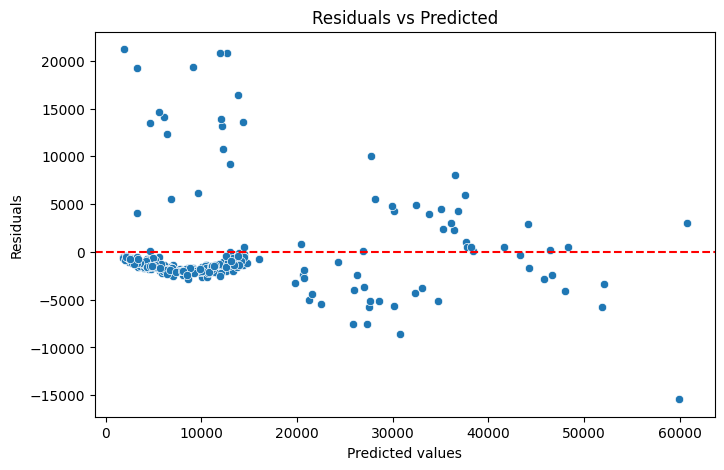

In [85]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()